In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_trained_path = '/content/drive/MyDrive/vgg16_trained_weights.h5'

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# create a baseline VGG16 model
# Define a function to create a modified VGG16 model
def  create_modified_vgg16 ( ) :
# Load the VGG16 model , pre−t r ai n e d on ImageNet , wi th ou t the top l a y e r
    base_model = tf.keras.applications.VGG16( include_top=False , input_shape =(32,32,3) , weights='imagenet' , pooling='avg' )
    # Freeze the l a y e r s o f the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Create the model
    model = models.Sequential()
    # Add the base model
    model.add(base_model)
    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.load_weights(model_trained_path)
    return model

In [ ]:
# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    gamma = 0.95
    return lr * gamma

In [ ]:
# Create and compile the model
modified_vgg16 = create_modified_vgg16()
optimizer = optimizers.SGD(learning_rate=0.03, momentum=0.9)
modified_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary o f the model
modified_vgg16.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 15111242 (57.64 MB)
Trainable params: 396554 (1.51 MB)
Non-trainable params: 14714688 (56.13 MB)
____________

In [ ]:
# Define the learning rate scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert class vectors to binary class matrices (for use with categorical_crossentropy)
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Calculate mean and standard deviation for each channel
mean = np.mean(train_images, axis=(0, 1, 2))
std = np.std(train_images, axis=(0, 1, 2))

# Normalize the training and test images using mean and standard deviation
train_images = (train_images - mean) / std
test_images = (test_images - mean) / std

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
# Adjust the batch size for training and test data loaders
trainloader = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(64)
testloader = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(64)

In [ ]:
# Train the model
history = modified_vgg16.fit(  train_images,
                  train_labels,
                  epochs=10, # You might need to adjust the number of epochs
                  validation_data=(test_images, test_labels),
                  callbacks=lr_callback)

# Evaluate the model
test_loss, test_acc = modified_vgg16.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1563/1563 [==============================] - 20s 12ms/step - loss: 0.6561 - accuracy: 0.7795 - val_loss: 0.6840 - val_accuracy: 0.7713 - lr: 9.5000e-04
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5963 - accuracy: 0.7966 - val_loss: 0.7070 - val_accuracy: 0.7596 - lr: 9.0250e-04
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5746 - accuracy: 0.8029 - val_loss: 0.6640 - val_accuracy: 0.7737 - lr: 8.5737e-04
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5609 - accuracy: 0.8063 - val_loss: 0.6478 - val_accuracy: 0.7766 - lr: 8.1451e-04
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5461 - accuracy: 0.8108 - val_loss: 0.6343 - val_accuracy: 0.7810 - lr: 7.7378e-04
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.5335 - accuracy: 0.8131 - val_loss: 0.6295 - val_accuracy: 0.7873 - lr: 7.3509e-04
Epoch 7/10
1563/1563 [

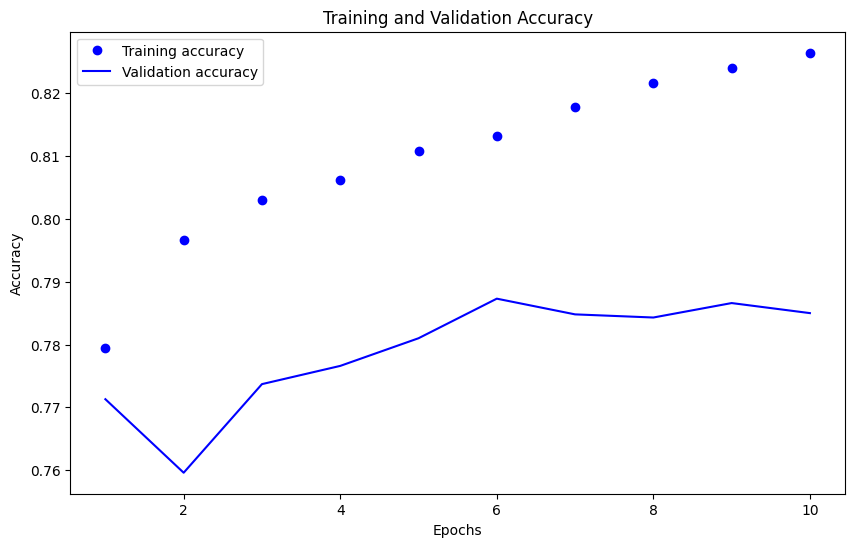

In [ ]:
import matplotlib.pyplot as plt

# Extracting the accuracy history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting both the training accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

313/313 [==============================] - 2s 7ms/step


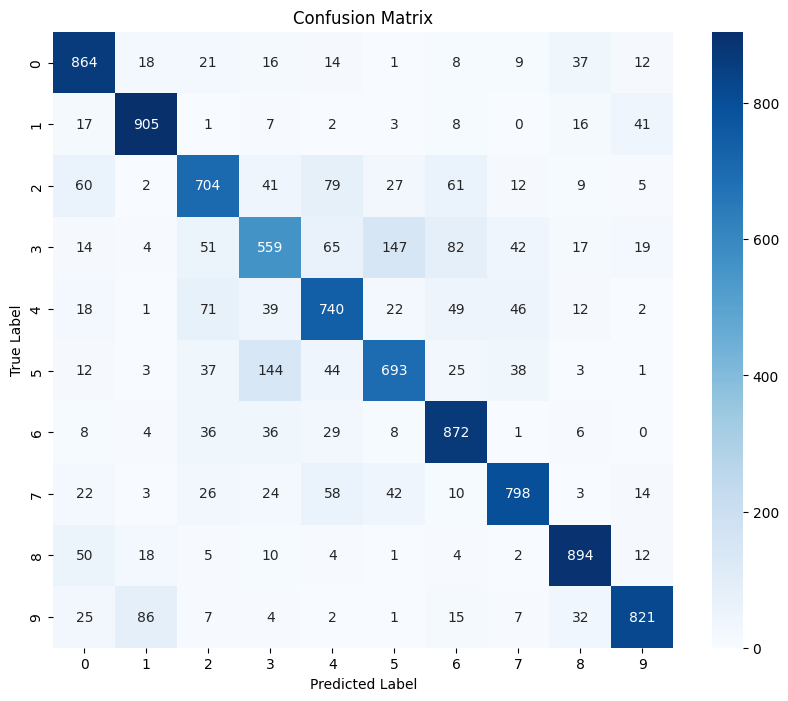

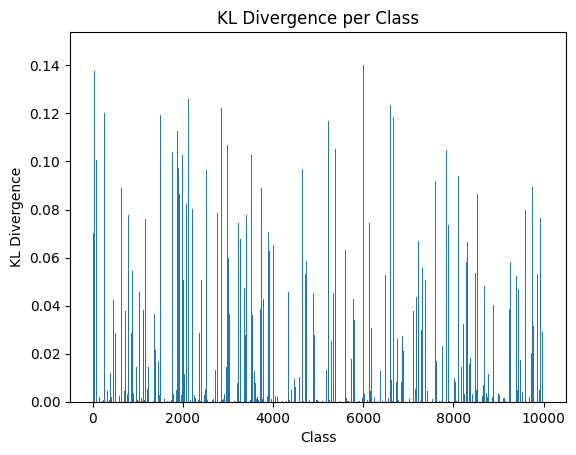

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import scipy

# Define softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Make predictions on test data
predictions = modified_vgg16.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Apply softmax to predicted and true distributions
predicted_softmax = softmax(predictions)
true_softmax = softmax(test_labels)

# Compute KL divergence between predicted and true distributions
kl_divergence = scipy.stats.entropy(predicted_softmax.T, true_softmax.T)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot KL divergence
plt.figure()
plt.bar(np.arange(len(kl_divergence)), kl_divergence)
plt.xlabel('Class')
plt.ylabel('KL Divergence')
plt.title('KL Divergence per Class')
plt.show()

Task 1: drop out randomly

In [ ]:
from tensorflow.keras.layers import Dropout

def create_modified_vgg16_with_dropout(dropout_rate):
    # Load the VGG16 model, pre-trained on ImageNet, without the top layer
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet', pooling='avg')
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Create the model
    model = models.Sequential()
    # Add the base model
    model.add(base_model)
    # Flatten the output
    model.add(layers.Flatten())
    # Add dropout to the last three layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [ ]:
# Function to apply temperature scaling to softmax outputs
def temperature_scaling(logits, temperature):
    scaled_logits = logits / temperature
    return tf.nn.softmax(scaled_logits)

In [ ]:
# Create an ensemble of models with dropout, KL divergence, and temperature scaling
num_models = 5
dropout_rate = 0.8  # 50% dropout rate
temperature = 1.0  # Temperature parameter for softmax

models_with_dropout_kl_temperature_scaling = []

for _ in range(num_models):
    model = create_modified_vgg16_with_dropout(dropout_rate)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    models_with_dropout_kl_temperature_scaling.append(model)

In [ ]:
# Retrain the five networks
epochs = 5
for model in models_with_dropout_kl_temperature_scaling:
    model.fit(train_images, train_labels, epochs=epochs, validation_data=(test_images, test_labels), callbacks=lr_callback)

# Use the ensemble of models during inference with temperature scaling
predictions = np.zeros_like(test_labels, dtype=float)
for model in models_with_dropout_kl_temperature_scaling:
    logits = model.predict(test_images)
    scaled_softmax = temperature_scaling(logits, temperature)
    predictions += scaled_softmax
predictions /= num_models

# Evaluate accuracy and reliability
ensemble_accuracy = np.mean(np.equal(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1)))
print("Ensemble Accuracy with KL Divergence and Temperature Scaling:", ensemble_accuracy)

NameError: name 'models_with_dropout_kl_temperature_scaling' is not defined